# Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import wget
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

# Creating and training binary classification model

In [2]:
if not os.path.isdir('data.resistell.com'):
    !wget -r --user=modelway --password=M0delWay! --reject="index.html" https://data.resistell.com/model_way/ds_recruitment/
    os.remove("data.resistell.com\model_way\ds_recruitment\index.html.tmp")

Method loadDataFromDirectory() is responisble for loading data and classes from file names. Data and classes are stored in two different arrays with corespodning indexes. 

In [3]:
directory = 'data.resistell.com/model_way/ds_recruitment'
def loadDataFromDirectory(directory, class_index):
    tmp_x = []
    tmp_y = []
    for filename in os.listdir(directory):
        file = os.path.join(directory, filename)
        with open(file, 'rb') as f:
            tmp = pickle.load(f) # deserialize using load()
            tmp_y.append(int(file[class_index]))
            tmp_x.append(tmp)
    return(tmp_x, tmp_y)

In [4]:
data, classes = loadDataFromDirectory(directory, 60)

In the cell below I check if there are any NaNs in the signals. Fortunatly, there was no missing values so interpolation wasn't needed. Moreover, each signal has the same length so I didn't have to add values to shorter ones or cut inputs from longer ones.

In [5]:
for i, j in enumerate(data):
    if np.count_nonzero(np.isnan(j)) != 0:
        print("There is a NaN in array number " + str(i) + " and there are " + str(np.count_nonzero(np.isnan(j))))

In [6]:
lin_x = np.linspace(1, len(data[1]), num = len(data[1]))
lin_x

array([1.000000e+00, 2.000000e+00, 3.000000e+00, ..., 5.119998e+06,
       5.119999e+06, 5.120000e+06])

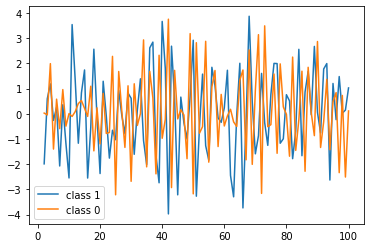

In [7]:
plt.figure()
plt.plot(lin_x[1:100], data[1][1:100], label = "class 1")
plt.plot(lin_x[1:100], data[2][1:100], label = "class 0")
plt.legend(loc="best")
plt.show()

Method extractFeatures() is responsible for extracting features of all given signals. In order to do so, method firstly does FFT on smaller signal composed of first 1 000 000 records from original signal from the data. I decided to use only first million instances because it greatly shortens the time of feature extraction and it doesn't have great effect on model accuracy. Then it calculates power spectral density. With PSD spectral centroid, skewness and standard deviation are calculated. Those three features are used later on for classification.

In [8]:
def extractFeatures(data):
    result =[]
    freq = np.fft.fftfreq(data[0].size, d=1)
    for i in tqdm(range(0, len(data))):
        fft = np.fft.fft(data[i][0:1000000])
        # Calculate the power spectral density (PSD)
        psd = np.abs(fft) ** 2 / len(fft)
        # Calculate the spectral centroid
        centroid = np.sum(psd * np.arange(len(fft))) / np.sum(psd)
        # Calculate the spectral skewness
        skewness = skew(psd)
        std_psd = psd.std()
        result.append([skewness, centroid,std_psd])
    result = np.array(result)
    return result

In [9]:
features = extractFeatures(data)
classes = np.array(classes)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.38it/s]


Extracted features have to be standardized before they can be used for training the model. The difference in magnitude between those features would greatly decrease model accuracy. 

In [10]:
mean = [features[:,0].mean(), features[:,1].mean(), features[:,2].mean()] 
std = [features[:,0].std(), features[:,1].std(), features[:,2].std()]
for i, j in enumerate(features):
    features[i, 0] = (features[i, 0] - mean[0])/(std[0])
    features[i, 1] = (features[i, 1] - mean[1])/(std[1])
    features[i, 2] = (features[i, 2] - mean[2])/(std[2])

In [11]:
df = pd.DataFrame(features, columns = ['Skewness', 'Centroid', 'Std'])
df['Class'] = classes
df.corr()

,Skewness,Centroid,Std,Class
Skewness,1.000000,-0.178785,-0.717864,-0.476605
Centroid,-0.178785,1.000000,0.140079,0.064659
Std,-0.717864,0.140079,1.000000,-0.065030
Class,-0.476605,0.064659,-0.065030,1.000000


As seen in the table above Skewness is most correlated with Class. In comparison, spectral centroid and standard deviation of PSD are not relevant. What is interesting without those features model presented worse predictions. In my opinion, even thought the correlation of those features with Class is unsatisfactory they should remain. When predicting on only one feature model could be more susceptible for overfitting.

I split data and classes into training and testing subsets. Training subset contains 80% and test subset contains 20% of data and classes arrays. 

In [12]:
data_train, data_test, classes_train, classes_test = train_test_split(features, classes, test_size=0.20, random_state=42)

In the cell below I train a simple logistic regression model and I save that model in a pickle file for future use.

In [13]:
log_reg = LogisticRegression()
log_reg.fit(data_train, classes_train)
pickle.dump(log_reg, open('logistic_reg_model.sav', 'wb'))
y_pred = log_reg.predict(data_test)

In [14]:
print('Accuracy:', accuracy_score(classes_test, y_pred))
print('Precision:', precision_score(classes_test, y_pred))
print('Recall:', recall_score(classes_test, y_pred))
print('F1-score:', f1_score(classes_test, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


In [15]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits= 5, shuffle=True, random_state=42)
i = 0
for train, test in kfold.split(features, np.array(classes)):
    i = i + 1
    log_reg = LogisticRegression()
    log_reg.fit(features[train], classes[train])
    y_pred = log_reg.predict(features[test])
    print(f"Fold {i}")
    print('Accuracy:', accuracy_score(classes[test], y_pred))
    print('Precision:', precision_score(classes[test], y_pred))
    print('Recall:', recall_score(classes[test], y_pred))
    print('F1-score:', f1_score(classes[test], y_pred))
    print('Number of class 1 instances in training data out of 20:', sum(classes[test]))


Fold 1
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Number of class 1 instances in training data out of 20: 12
Fold 2
Accuracy: 0.95
Precision: 0.9090909090909091
Recall: 1.0
F1-score: 0.9523809523809523
Number of class 1 instances in training data out of 20: 10
Fold 3
Accuracy: 0.75
Precision: 0.6
Recall: 0.8571428571428571
F1-score: 0.7058823529411764
Number of class 1 instances in training data out of 20: 7
Fold 4
Accuracy: 0.85
Precision: 1.0
Recall: 0.7692307692307693
F1-score: 0.8695652173913044
Number of class 1 instances in training data out of 20: 13
Fold 5
Accuracy: 0.75
Precision: 0.7
Recall: 0.7777777777777778
F1-score: 0.7368421052631577
Number of class 1 instances in training data out of 20: 9


In the cells above one can see that model is very accurate. Mean of accuracies from kfold cross validation is equal to 86%. Model trains lightining fast and prediction takes a fraction of an second as well. Biggest time loss during prediction is preprocessing. Feature extraction takes around ten seconds to complete.

Method makePreiction() takes three arguments. First is data on which model has to make predicitons. Second is an array with classes which is used for evaluating predictions. Third argument is the path to the pickle file with saved model. Method does feature extraction given data, loads model, makes predictions and then evaluates them. 

In [16]:
def makePreiction(data, classes, path_to_model):
    result = []
    model = pickle.load(open(path_to_model, 'rb'))
    features = extractFeatures(data)
    
    mean = [features[:,0].mean(), features[:,1].mean(), features[:,2].mean()] 
    std = [features[:,0].std(), features[:,1].std(), features[:,2].std()]
    for i, j in enumerate(features):
        features[i, 0] = (features[i, 0] - mean[0])/(std[0])
        features[i, 1] = (features[i, 1] - mean[1])/(std[1])
        features[i, 2] = (features[i, 2] - mean[2])/(std[2])
    
    y_pred = model.predict(features)
    print('Accuracy:', accuracy_score(classes, y_pred))
    print('Precision:', precision_score(classes, y_pred))
    print('Recall:', recall_score(classes, y_pred))
    print('F1-score:', f1_score(classes, y_pred))
    
    return y_pred

In [18]:
prediction = makePreiction(data, classes, 'logistic_reg_model.sav')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.89it/s]

Accuracy: 0.89
Precision: 0.8846153846153846
Recall: 0.9019607843137255
F1-score: 0.8932038834951457


In [19]:
confusion_matrix(prediction, classes)

array([[43,  5],
       [ 6, 46]], dtype=int64)